In [1]:
from __future__ import print_function,division
%matplotlib inline
import os, sys, datetime, glob
from collections import OrderedDict
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

from importlib import reload # Python 3

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import datastream, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'Set1'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
   
imwidth = 256
imheight = 256
numimgs = 500
numClasses=2   

learningRate=1e-4
trainSteps=500
batchSize=20
filters=(4, 8, 16, 32, 64)
strides=(2, 2,  2,  2)
resunits=1
kernelsize=3

1.0.1


float32 (20, 1, 256, 256) int32 (20, 1, 256, 256)


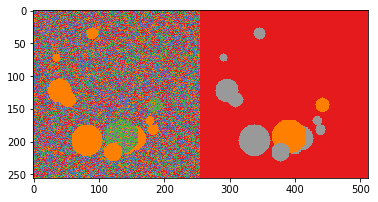

In [2]:
stream=datastream.TestImageGenerator(imwidth,imheight,noiseMax=1.0,numSegClasses=numClasses)

src=datastream.ThreadAugmentStream(stream,batchSize,augments=[pytorchutils.convert])

gen=src.getGenFunc()
im,mask=gen()
print(im.dtype,im.shape,mask.dtype,mask.shape)
plt.imshow(np.hstack([im[0,0],mask[0,0]]))

In [3]:
class UnetMgrNB(pytorchutils.SegmentMgr,trainutils.JupyterThreadMonitor):
    def __init__(self,net,src,batchSize,trainSteps):
        trainutils.JupyterThreadMonitor.__init__(self)
        pytorchutils.SegmentMgr.__init__(self,net)
        self.src=src
        self.batchSize=batchSize
        self.trainSteps=trainSteps
        
    def run(self):
        self.train(self.src.getGenFunc(),self.trainSteps,1,10)
        
    def updateStep(self,step,steploss):
        self.updateGraphVals({'loss':steploss},('loss',))
        
        if step<10 or step%5==0:
            images,segs=self.traininputs
            logits,preds=self.netoutputs

            image=self.toNumpy(images[0,0])
            seg=self.toNumpy(segs[0,0])
            logit=self.toNumpy(logits[0].sum(0))
            pred=self.toNumpy(preds[0])
            
            imgmap=OrderedDict([
                ('Image',image),
                ('Seg',seg),
                ('Logit',logit),
                ('Pred',pred),
                ('Diff',trainutils.compareSegsRGB(seg,pred,3)),
            ])
            
            self.updateImageVals(imgmap)

net=pytorchnet.Unet(1,numClasses+1,filters,strides,kernelsize)

mgr=UnetMgrNB(net,src,batchSize,trainSteps)

mgr.start()

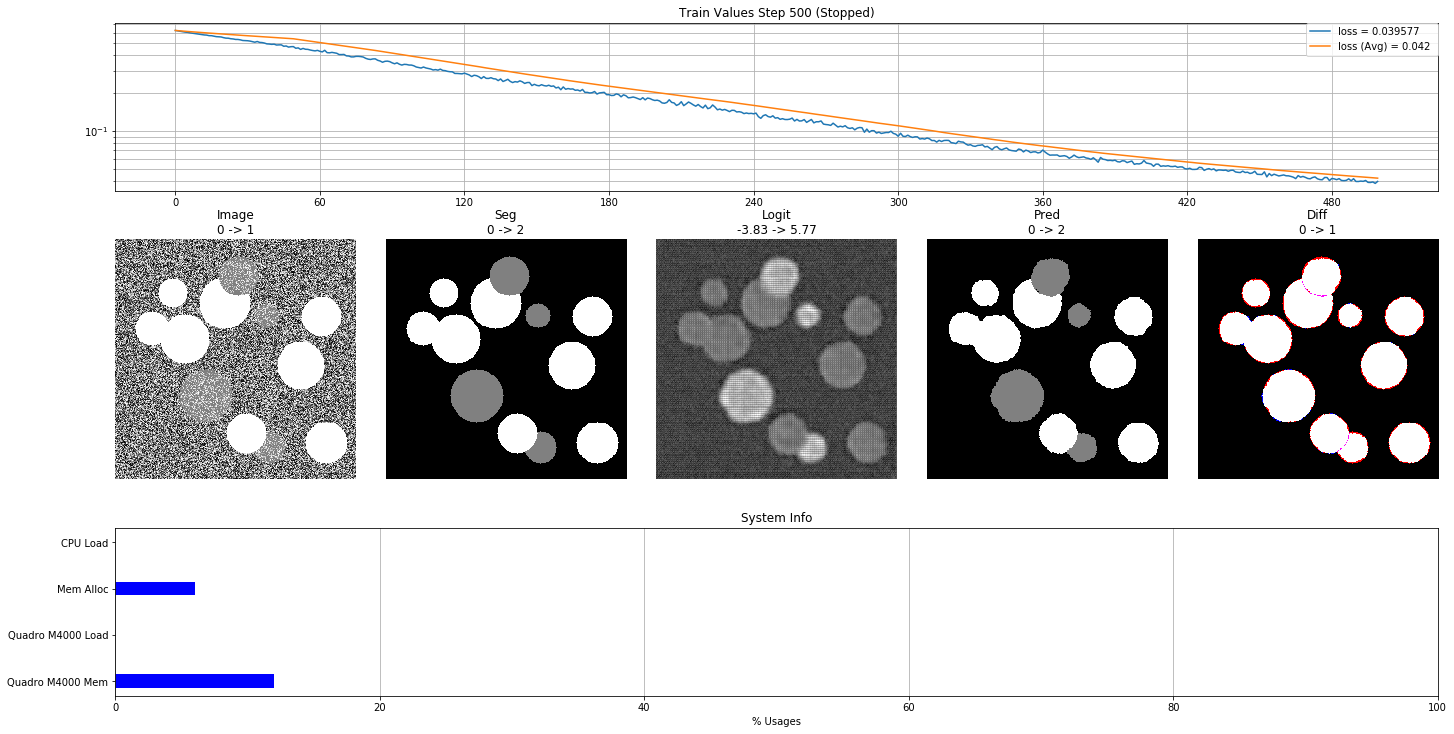

In [4]:
mgr.displayMonitor()

In [5]:
resnet=pytorchnet.Unet(1,numClasses+1,filters,strides,kernelsize,numResUnits=resunits)

resmgr=UnetMgrNB(resnet,src,batchSize,trainSteps)

resmgr.start()

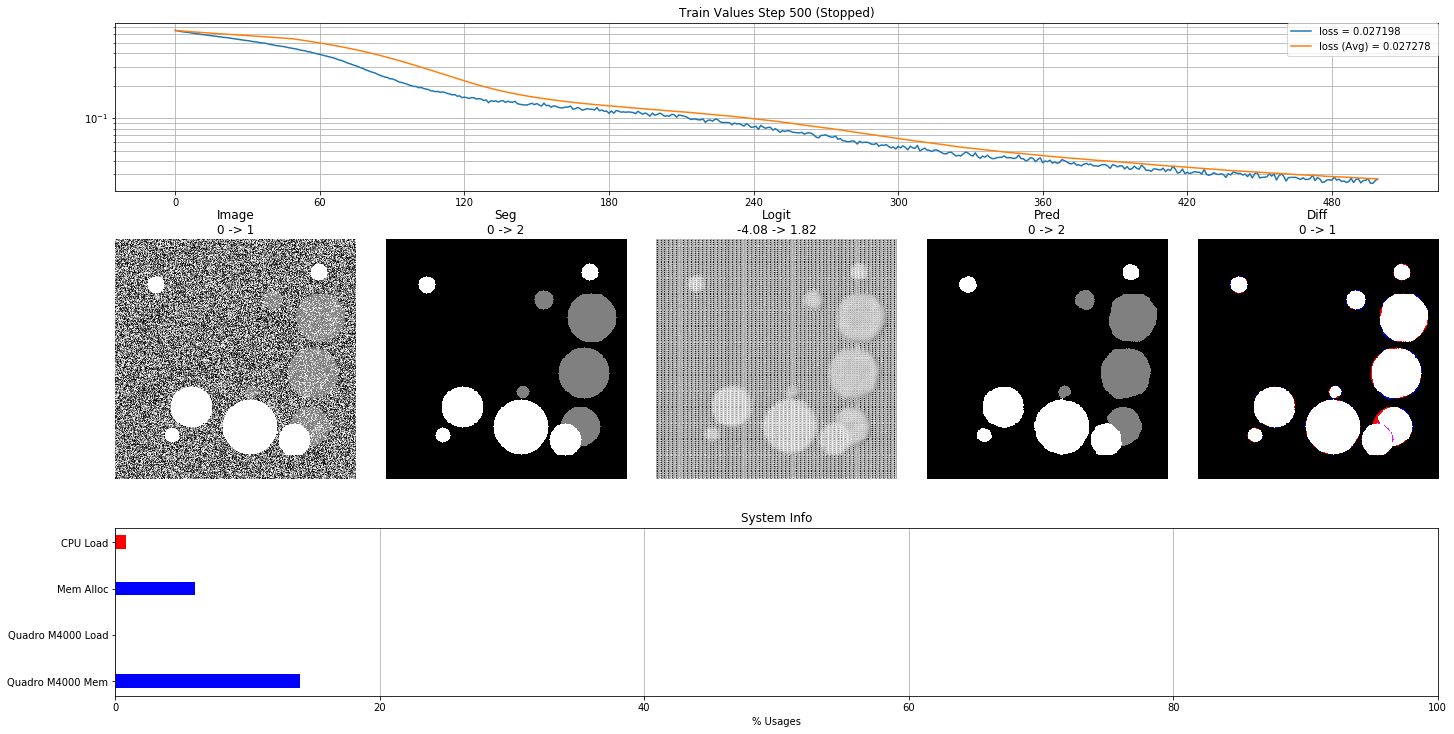

In [6]:
resmgr.displayMonitor()